In [96]:
import pandas as pd
import numpy as np
import sys
import folium
import folium.plugins as fp
%matplotlib inline
import matplotlib.pyplot as plt
import math
import seaborn as sns
import geopandas as gpd
from shapely.ops import nearest_points
from shapely.geometry import LineString

In [97]:
vancouver=pd.read_json('amenities-vancouver.json',lines=True)
vancouver=vancouver.dropna()

In [98]:
amenity=vancouver.groupby('amenity').count()
#amenity.to_csv('numberofamenities.csv')
amenity=amenity.reset_index() 

In [99]:
AirbnbListings=pd.read_csv('listings.csv')

In [100]:
#for col in AirbnbListings.columns:
#    print(col)

In [101]:
AirbnbListings=AirbnbListings[AirbnbListings['number_of_reviews']>90]
AirbnbListings=AirbnbListings[AirbnbListings['number_of_reviews']>25]
AirbnbListings=AirbnbListings[AirbnbListings['last_review']>'2020-01-01']
AirbnbListings=AirbnbListings[['latitude','longitude','amenities','review_scores_accuracy',
                               'review_scores_cleanliness','review_scores_checkin',
                               'review_scores_communication','price',
                               'review_scores_value','review_scores_rating']]
AirbnbListings=AirbnbListings.dropna()
AirbnbListings=AirbnbListings.rename(columns={'latitude':'lat','longitude':'lon'})

In [102]:
#just checking how the join would work
#pd.merge(vancouver,AirbnbListings,how='outer',left_on=['lat'],right_on=['latitude'])


In [103]:
outdooracivties = vancouver[(vancouver['amenity'] == 'bicycle_parking')|(vancouver['amenity'] == 'bench')|
                            (vancouver['amenity'] == 'leisure')|(vancouver['amenity'] == 'park')]

In [104]:
nightlife = vancouver[(vancouver['amenity']=='bar')|(vancouver['amenity']=='lounge')|(vancouver['amenity']=='nightclub')|
                      (vancouver['amenity']=='stripclub')|(vancouver['amenity']=='pub')
                     |(vancouver['amenity']=='internet_cafe')|(vancouver['amenity']=='casino')]

In [105]:
food = vancouver[(vancouver['amenity']=='bbq')| (vancouver['amenity']=='restaurant')|(vancouver['amenity']=='ice_cream')|
                 (vancouver['amenity']=='bistro')| (vancouver['amenity']=='cafe')]

In [164]:
allactivities = outdooracivties.append(nightlife).append(food)


In [107]:

#locations = AirbnbListings[['lat', 'lon']]
#locationlist = locations.values.tolist()

#map =folium.Map(location=[49.14, -122.65], zoom_start=10)

#marker_cluster = fp.MarkerCluster().add_to(map)

#for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point]).add_to(marker_cluster)

#map

In [108]:
def color_of_map(vancouver):
    if((vancouver['amenity'] == 'bicycle_parking')|(vancouver['amenity'] == 'bench')|
                            (vancouver['amenity'] == 'leisure')|(vancouver['amenity'] == 'park')):
        return 'red'
    elif ((vancouver['amenity']=='bar')|(vancouver['amenity']=='lounge')|(vancouver['amenity']=='nightclub')|
                      (vancouver['amenity']=='stripclub')|(vancouver['amenity']=='pub')
                     |(vancouver['amenity']=='internet_cafe')|(vancouver['amenity']=='casino')):
        return 'purple'
    elif (vancouver['amenity']=='restaurant'):
        return 'pink'
    elif (vancouver['amenity']=='cafe'):
        return 'green'
    else:
        return 'blue'

In [179]:
def make_circle(p, m, r=1):
    folium.CircleMarker(
        location=[p['lat'], p['lon']],
        radius=r,
        color = color_of_map(p)
    ).add_to(m)

In [181]:
def make_circle_Airbnb(p, m, c , r=1):
    folium.CircleMarker(
        location=[p['lat'], p['lon']],
        radius=r,
        color = c
    ).add_to(m)

In [161]:
def circle_of_amenities(df):
    van_map = folium.Map(location=[49.14, -122.65], zoom_start=10)
    activites = folium.map.FeatureGroup()
    df.apply(make_circle, axis=1, m=activites)
    return van_map.add_child(activites)

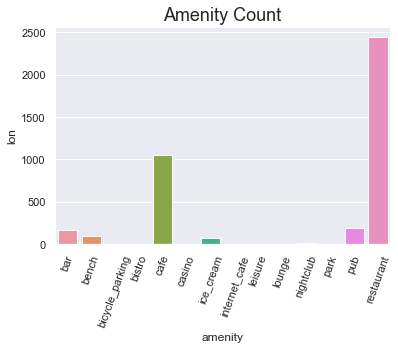

In [113]:
AmenityCount = allactivties.groupby('amenity').count().reset_index()
sns.set()
pic = sns.barplot(AmenityCount['amenity'],AmenityCount['lon'])
plt.xticks(rotation=70)
plt.title('Amenity Count',fontsize = 18)
plt.show()

In [180]:
circle_of_amenities(allactivities)

In [163]:
circle_of_amenities(nightlife)

In [116]:
def create_gdf(df, x="lon", y="lat"):
    return gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df[x], df[y]), crs={"init":"epsg:4326"})

In [117]:
AirbnbListings_gdf = create_gdf(AirbnbListings)
vancouver_gdf = create_gdf(allactivities)

c:\users\bobby\desktop\cmpt353\env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [118]:
def calculate_nearest(row, destination, val, col="geometry"):
    dest_unary = destination["geometry"].unary_union
    nearest_geom = nearest_points(row[col], dest_unary)
    match_geom = destination.loc[destination.geometry == nearest_geom[1]]
    match_value = match_geom[val].to_numpy()[0]
    return match_value

In [119]:
vancouver_gdf

lat         lon                      timestamp           amenity  \
0      49.260812 -123.125736  2020-03-20T18:22:12.000-07:00              cafe   
1      49.260953 -123.125704  2019-08-02T18:11:20.000-07:00         fast_food   
4      49.370898 -123.280448  2015-05-03T00:42:25.000-07:00  place_of_worship   
7      49.264041 -123.153407  2019-08-29T18:50:05.000-07:00              fuel   
13     49.126650 -123.182470  2020-03-30T09:08:51.000-07:00        restaurant   
...          ...         ...                            ...               ...   
17712  49.250408 -123.076261  2017-07-08T05:22:57.000-07:00        restaurant   
17713  49.278424 -122.806704  2013-03-26T23:45:49.000-07:00              cafe   
17714  49.278770 -122.797628  2013-03-26T23:45:49.000-07:00        restaurant   
17716  49.282666 -122.826978  2019-09-13T13:56:49.000-07:00               pub   
17717  49.282420 -122.826340  2019-09-13T13:56:49.000-07:00              cafe   

                               name  \
0                         Starbucks   
1                        Salad Loop   
4      St. Monica's Anglican Church   
7                             Shell   
13         Best Bite Indian Cuisine   
...                             ...   
17712                House of Dosas   
17713              Creekside Coffee   
17714                    Togo Sushi   
17716          Brown's Social House   
17717              Gallagher's Cafe   

                                                    tags  \
0      {'brand:wikidata': 'Q37158', 'official_name': ...   
1      {'opening_hours': 'Mo-Fr 07:00-17:00; Sa 10:00...   
4      {'addr:housenumber': '6404', 'addr:street': 'W...   
7      {'brand:wikidata': 'Q154950', 'addr:housenumbe...   
13     {'addr:housenumber': '10-3891', 'phone': '+1-6...   
...                                                  ...   
17712  {'addr:housenumber': '1391', 'phone': '+1-604-...   
17713                                                 {}   
17714                            {'cuisine': 'japanese'}   
17716  {'addr:housenumber': '215', 'brewery': 'Guinne...   
17717  {'addr:housenumber': '232', 'internet_access':...   

                          geometry  
0      POINT (-123.12574 49.26081)  
1      POINT (-123.12570 49.26095)  
4      POINT (-123.28045 49.37090)  
7      POINT (-123.15341 49.26404)  
13     POINT (-123.18247 49.12665)  
...                            ...  
17712  POINT (-123.07626 49.25041)  
17713  POINT (-122.80670 49.27842)  
17714  POINT (-122.79763 49.27877)  
17716  POINT (-122.82698 49.28267)  
17717  POINT (-122.82634 49.28242)  

[8169 rows x 7 columns]

In [120]:
AirbnbListings_gdf["nearest_point"] = AirbnbListings_gdf.apply(calculate_nearest, 
                                                              destination=vancouver_gdf, val="geometry", axis=1)

In [121]:

AirbnbListings_gdf["nearest_amenity"] = AirbnbListings_gdf.apply(calculate_nearest, 
                                                                 destination=vancouver_gdf, val="amenity", axis=1)

In [126]:
AirbnbListings_gdf['line'] = AirbnbListings_gdf.apply(lambda row: LineString([row['geometry'], row['nearest_point']]), axis=1)

In [127]:
line_gdf = AirbnbListings_gdf[["nearest_amenity", "line"]].set_geometry('line')

In [128]:
line_gdf.crs = crs={"init":"epsg:4326"}

c:\users\bobby\desktop\cmpt353\env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [130]:
AirbnbListings_gdf.drop(["nearest_point", "line"], axis=1, inplace=True)

In [184]:
m = folium.Map([49.14, -122.65],
               zoom_start = 10)

hotel =folium.map.FeatureGroup()
activitiesHotel = folium.map.FeatureGroup()

AirbnbListings.iloc[:,0:2].apply(make_circle_Airbnb, axis=1, m=hotel,c ="orange", r =2)
allactivties.apply(make_circle, axis=1, m=activitiesHotel,r=2)

hotel.add_to(m)
activitiesHotel.add_to(m)
folium.GeoJson(line_gdf).add_to(m)

m